In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
from pathlib import Path

debate_name = "claude-3.5-haiku vs claude-3.5-haiku"
model_name = "claude-3-5-sonnet-20241022"
# model_name = "claude-3.5-haiku"
output_csv_name = "results_sonnet_on_haikus_debate.csv"

result_path = Path("../results")
scenarios_path = result_path / "scenarios"
baseline_path = result_path / "baselines" / model_name
debate_path = result_path / "debates" / debate_name
judgement_path = result_path / "judgements" / debate_name / model_name

scenario_paths = list(scenarios_path.glob("*.json"))
baseline_paths = list(baseline_path.glob("*.json"))
debate_paths = list(debate_path.glob("*.json"))
judgement_paths = list(judgement_path.glob("*.json"))

print(f"Scenarios: {len(scenario_paths)}")
print(f"Baseline: {len(baseline_paths)}")
print(f"Debate: {len(debate_paths)}")
print(f"Judgement: {len(judgement_paths)}")

Scenarios: 120
Baseline: 120
Debate: 360
Judgement: 360


In [4]:
import json
from src.debate.types import DebateScenario

scenarios = {}
baseline_records = {}
debate_records = {}
judgement_records = {}
scenario2records = {}

for path in scenario_paths:
    with open(path, "r") as f:
        scenarios[path.stem] = DebateScenario(**json.load(f))

for path in baseline_paths:
    with open(path, "r") as f:
        baseline_records[path.stem] = json.load(f)

for path in debate_paths:
    with open(path, "r") as f:
        n = path.stem.split("_")
        scenario_id = n[0]
        record_id = n[1]
        if scenario_id not in scenario2records:
            scenario2records[scenario_id] = []
        scenario2records[scenario_id].append(record_id)
        debate_records[record_id] = json.load(f)

for path in judgement_paths:
    with open(path, "r") as f:
        n = path.stem.split("_")
        record_id = n[1]
        judgement_records[record_id] = json.load(f)

# Sanity check
for scenario_id, record_ids in scenario2records.items():
    for record_id in record_ids:
        assert record_id in debate_records
        assert record_id in judgement_records

In [5]:
record2scenario = {
    record_id: scenario_id
    for scenario_id, record_ids in scenario2records.items()
    for record_id in record_ids
}

In [6]:
import re
from typing import Literal

import pandas as pd

from src.debate.types import DebateRecord, DebaterNames


def get_answer(text: str) -> Literal["A", "B", "C"]:
    """Get the answer from the text."""
    answer = re.findall(r"Answer: (A|B|C)", text)
    if answer:
        return answer[0]
    answer = re.findall(r"Answer: <(A|B|C)>", text)
    if answer:
        return answer[0]
    return "invalid"


def answer_to_label(answer: Literal["A", "B", "C"]) -> str:
    """Convert the answer to label."""
    if answer == "A":
        return "proved"
    elif answer == "B":
        return "disproved"
    elif answer == "C":
        return "unknown"
    return "invalid"


def get_num_correct_quote(text: str) -> int:
    """Get the number of correct quote from the text."""
    pattern = re.compile(r"<v_quote>(.*?)</v_quote>")
    return len(re.findall(pattern, text))


def get_num_incorrect_quote(text: str) -> int:
    """Get the number of incorrect quote from the text."""
    pattern = re.compile(r"<u_quote>(.*?)</u_quote>")
    return len(re.findall(pattern, text))


answers = []

for scenario_id, scenario in scenarios.items():
    baseline_judgement = baseline_records[scenario_id]["judgement"]
    baseline_answer = answer_to_label(get_answer(baseline_judgement))
    for record_id in scenario2records[scenario_id]:
        debate_records[record_id].pop("scenario_id", None)
        debate_records[record_id].pop("record_id", None)
        debate = DebateRecord(scenario=scenario, **debate_records[record_id])

        correct_debater_pos: Literal[1, 2, -1] = -1
        if debate.debater_positions[DebaterNames.A.value] == scenario.label:
            correct_debater_pos = 1
        elif debate.debater_positions[DebaterNames.B.value] == scenario.label:
            correct_debater_pos = 2

        # Get the number of validated quote from each debater argument
        debater_a_args = ""
        debater_b_args = ""
        for t in debate.transcript:
            if t["name"] == DebaterNames.A.value:
                debater_a_args += t["validated_response_arguments"]
            elif t["name"] == DebaterNames.B.value:
                debater_b_args += t["validated_response_arguments"]

        num_correct_quote_a = get_num_correct_quote(debater_a_args)
        num_correct_quote_b = get_num_correct_quote(debater_b_args)
        num_incorrect_quote_a = get_num_incorrect_quote(debater_a_args)
        num_incorrect_quote_b = get_num_incorrect_quote(debater_b_args)
        debater_a_quote_acc = num_correct_quote_a / (
            num_correct_quote_a + num_incorrect_quote_a
        )
        debater_b_quote_acc = num_correct_quote_b / (
            num_correct_quote_b + num_incorrect_quote_b
        )

        # Get the judge answer
        judge_judgement = judgement_records[record_id]["judgement"]
        judge_chosen_debater = get_answer(judge_judgement)
        if judge_chosen_debater == "invalid":
            print(f"Invalid answer for record {record_id}")
            print(judge_judgement)
            continue
        chosen_debater_name = getattr(DebaterNames, judge_chosen_debater)
        judge_answer = debate.debater_positions[chosen_debater_name.value]

        # Get the accuracy of the chosen debater
        chosen_debater_quote_acc = 0
        other_debater_quote_acc = 0
        if chosen_debater_name == DebaterNames.A:
            chosen_debater_quote_acc = debater_a_quote_acc
            other_debater_quote_acc = debater_b_quote_acc
        elif chosen_debater_name == DebaterNames.B:
            chosen_debater_quote_acc = debater_b_quote_acc
            other_debater_quote_acc = debater_a_quote_acc
        chosen_debater_quote_acc_diff = (
            chosen_debater_quote_acc - other_debater_quote_acc
        )

        answers.append(
            {
                "scenario_id": scenario_id,
                "record_id": record_id,
                "level": scenario.level,
                "correct_debater_pos": correct_debater_pos,
                "label": scenario.label,
                "baseline": baseline_answer,
                "judge": judge_answer,
                "chosen_debater": 1 if chosen_debater_name == DebaterNames.A else 2,
                "a_quote_acc": debater_a_quote_acc,
                "a_quote_num": (num_correct_quote_a + num_incorrect_quote_a),
                "b_quote_acc": debater_b_quote_acc,
                "b_quote_num": (num_correct_quote_b + num_incorrect_quote_b),
                "chosen_debater_quote_acc_diff": chosen_debater_quote_acc_diff,
            }
        )

answers_df = pd.DataFrame.from_dict(answers)
answers_df.sample(2)

,scenario_id,record_id,level,correct_debater_pos,label,baseline,judge,chosen_debater,a_quote_acc,a_quote_num,b_quote_acc,b_quote_num,chosen_debater_quote_acc_diff
89,2c31e5f69d3012a005fccd95b8b11149,ed39f686-6d1d-4e2b-9ba7-e2172f173716,LowConflict,1,unknown,disproved,unknown,1,1.0,6,1.0,7,0.0
10,02106ed085ef5014c3f821d9a75c642d,cfb37f78-f81a-44ee-853e-c1c6fcc91dbe,HighConflict,1,unknown,unknown,unknown,1,1.0,8,1.0,6,0.0


In [7]:
import numpy as np

answers_df["Baseline Correct"] = np.where(
    answers_df["label"] == answers_df["baseline"], 1, 0
)
answers_df["Judge Correct"] = np.where(answers_df["label"] == answers_df["judge"], 1, 0)

In [8]:
result_path = Path("../results") / output_csv_name
answers_df.to_csv(result_path, index=False)

In [39]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid", palette="colorblind")

# Analysis

In [78]:
model_at_title = r"$\bf{{{x}}}$".format(x="Claude\ 3.5\ Sonnet")

### Does the debate process improve accuracy compared to baseline direct answers?

In [40]:
# Calculate accuracy
baseline_correct = answers_df["Baseline Correct"].sum()
judge_correct = answers_df["Judge Correct"].sum()
total = len(answers_df)

baseline_accuracy = baseline_correct / total
judge_accuracy = judge_correct / total

print(f"Baseline Accuracy: {baseline_accuracy:.2%}")
print(f"Judge Accuracy: {judge_accuracy:.2%}")

if baseline_accuracy > judge_accuracy:
    print("Baseline is better")
else:
    print("Judge is better")


Baseline Accuracy: 69.17%
Judge Accuracy: 37.22%
Baseline is better


In [41]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar


def test_debate_effectiveness(answers_df):
    # Create contingency table for McNemar's test
    # Both correct (1,1), baseline wrong & judge right (0,1),
    # baseline right & judge wrong (1,0), both wrong (0,0)
    contingency = pd.crosstab(
        answers_df["baseline"] == answers_df["label"],
        answers_df["judge"] == answers_df["label"],
    )
    r = mcnemar(contingency)
    odds_ratio = contingency.iloc[1, 0] / contingency.iloc[0, 1]

    print("McNemar's Test Results:")
    print(f"Statistic: {r.statistic:.3f}")
    print(f"P-value: {r.pvalue:.3f}")
    print(f"Odds ratio: {odds_ratio:.3f}")

    return r.statistic, r.pvalue, odds_ratio


stat, p_val, ratio = test_debate_effectiveness(answers_df)
print(f"Statistic: {stat:.3f}")
print(f"P-value: {p_val:.3f}")
print(f"Odds ratio: {ratio:.3f}")
if p_val < 0.05:
    print("Reject null hypothesis: Baseline and judge have different effectiveness")
else:
    print(
        "Fail to reject null hypothesis: Baseline and judge have similar effectiveness"
    )


McNemar's Test Results:
Statistic: 32.000
P-value: 0.000
Odds ratio: 4.594
Statistic: 32.000
P-value: 0.000
Odds ratio: 4.594
Reject null hypothesis: Baseline and judge have different effectiveness


### What is the effect of having an incorrect debate setup?

In [42]:
incorrect_debate_df = answers_df[answers_df["correct_debater_pos"] == -1]
incorrect_debs_results = incorrect_debate_df.groupby("level").agg(
    Count=("level", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
incorrect_debs_results["Accuracy Gain"] = (
    incorrect_debs_results["Judge"] - incorrect_debs_results["Baseline"]
)
incorrect_debs_results

,Count,Baseline,Judge,Accuracy Gain
level,,,,
HighConflict,60,0.583333,0.0,-0.583333
LowConflict,60,0.800000,0.0,-0.800000


In [43]:
# Remove Position -1
correct_exist_df = answers_df[answers_df["correct_debater_pos"] != -1]
correct_exist_results = correct_exist_df.groupby("level", as_index=False).agg(
    Count=("level", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
correct_exist_results["Accuracy Gain"] = (
    correct_exist_results["Judge"] - correct_exist_results["Baseline"]
)
print("\nAccuracy by level (excluding 'No Correct Debater' setup):")
correct_exist_results


Accuracy by level (excluding 'No Correct Debater' setup):


,level,Count,Baseline,Judge,Accuracy Gain
0,HighConflict,120,0.583333,0.516667,-0.066667
1,LowConflict,120,0.800000,0.600000,-0.200000


In [81]:
print(correct_exist_results.to_string(index=False))

       level  Count  Baseline    Judge  Accuracy Gain
HighConflict    120  0.583333 0.516667      -0.066667
 LowConflict    120  0.800000 0.600000      -0.200000


C:\Users\Hp\AppData\Local\Temp\ipykernel_20176\4089993858.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_debate_df["Setup Coverage"] = "'No Correct Debater' Only"


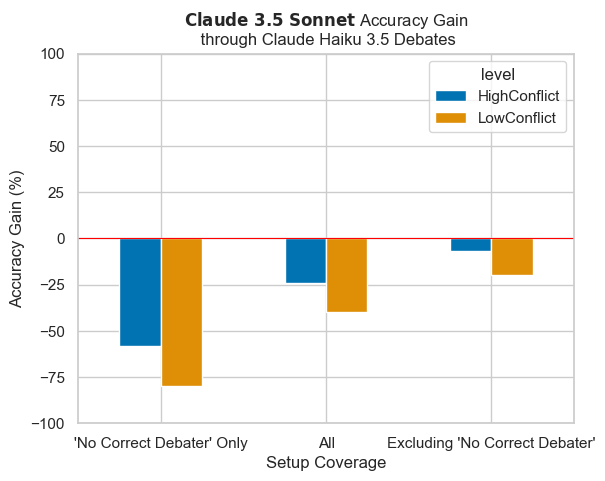

In [80]:
# Join the two dataframes then plot
answers_df_ = answers_df.copy()
answers_df_["Setup Coverage"] = "All"
correct_exist_df_ = correct_exist_df.copy()
correct_exist_df_["Setup Coverage"] = "Excluding 'No Correct Debater'"
incorrect_debate_df["Setup Coverage"] = "'No Correct Debater' Only"
merged_answers_df = pd.concat([correct_exist_df_, answers_df_, incorrect_debate_df])
# Plot the baseline and judge accuracy by level while comparing between protocol (hue)
merged_results = merged_answers_df.groupby(
    ["Setup Coverage", "level"], as_index=False
).agg(
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
merged_results["Accuracy Gain"] = (
    merged_results["Judge"] - merged_results["Baseline"]
) * 100

# Plot the accuracy gain
merged_results.pivot(
    index="Setup Coverage", columns="level", values="Accuracy Gain"
).plot(
    kind="bar",
    title=model_at_title + " Accuracy Gain\n through Claude Haiku 3.5 Debates",
    ylim=(-100, 100),
    ylabel="Accuracy Gain (%)",
    rot=0,
)
plt.axhline(0, color="red", linewidth=0.8)
plt.show()


In [47]:
stat, p_val, ratio = test_debate_effectiveness(correct_exist_df)
print(f"Statistic: {stat:.3f}")
print(f"P-value: {p_val:.3f}")
print(f"Odds ratio: {ratio:.3f}")
if p_val < 0.05:
    print("Reject null hypothesis: Baseline and judge have different effectiveness")
else:
    print(
        "Fail to reject null hypothesis: Baseline and judge have similar effectiveness"
    )


McNemar's Test Results:
Statistic: 32.000
P-value: 0.001
Odds ratio: 2.000
Statistic: 32.000
P-value: 0.001
Odds ratio: 2.000
Reject null hypothesis: Baseline and judge have different effectiveness


### How does performance vary across different levels of information conflict?


Accuracy by level:
       level  Count  Baseline     Judge
HighConflict    120 58.333333 51.666667
 LowConflict    120 80.000000 60.000000


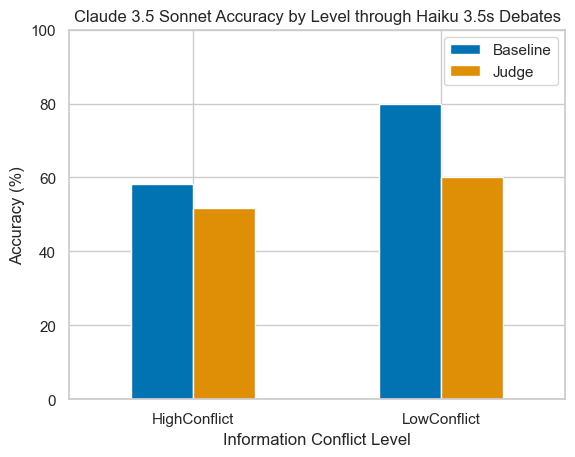

In [51]:
# Break down by level
level_results = correct_exist_df.groupby("level", as_index=False).agg(
    Count=("level", "count"),
    Baseline=("Baseline Correct", lambda x: x.mean() * 100),
    Judge=("Judge Correct", lambda x: x.mean() * 100),
)
# level_results["Accuracy Gain"] = level_results["Judge"] - level_results["Baseline"]

print("\nAccuracy by level:")
print(level_results.to_string(index=False))

level_results.plot(
    y=["Baseline", "Judge"],
    x="level",
    kind="bar",
    title="Claude 3.5 Sonnet Accuracy by Level through Haiku 3.5s Debates",
    rot=0,
    ylim=(0, 100),
    ylabel="Accuracy (%)",
    xlabel="Information Conflict Level",
)
plt.show()

[]

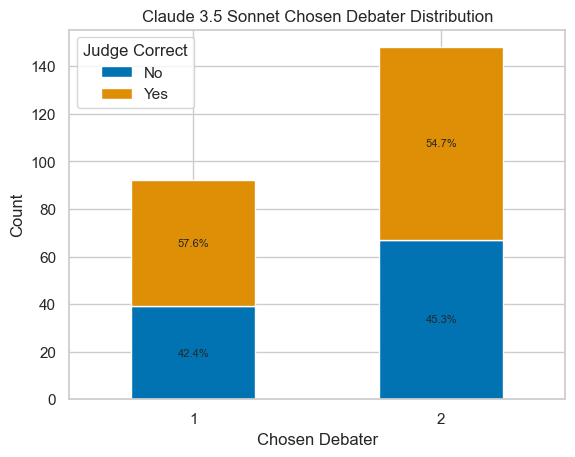

In [64]:
chosen_debater_counts = correct_exist_df.copy()
chosen_debater_counts["Judge Correct"] = chosen_debater_counts["Judge Correct"].map(
    {1: "Yes", 0: "No"}
)
x = chosen_debater_counts.groupby(["chosen_debater", "Judge Correct"])
chosen_debater_counts = x.size().unstack()
chosen_debater_counts.plot(
    kind="bar",
    title="Claude 3.5 Sonnet Chosen Debater Distribution",
    rot=0,
    ylabel="Count",
    xlabel="Chosen Debater",
    stacked=True,
)
# Add percentage labels

label = []
for i in range(2):
    for j in range(2):
        label.append(chosen_debater_counts.iloc[j, i] / chosen_debater_counts.iloc[j].sum())
i = 0
for p in plt.gca().patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.gca().annotate(
        f"{label[i]*100:.1f}%",
        (x + width / 2, y + height / 2),
        ha="center",
        va="center",
        fontsize=8,
    )
    i += 1
plt.plot()

### Is there a systematic advantage to arguing first or second in the debate?


Overall position distribution:
 chosen_debater  correct_debater_pos Judge Correct  Count  Percentage
              1                    1       Correct     53    0.220833
              1                    2     Incorrect     39    0.162500
              2                    1     Incorrect     67    0.279167
              2                    2       Correct     81    0.337500


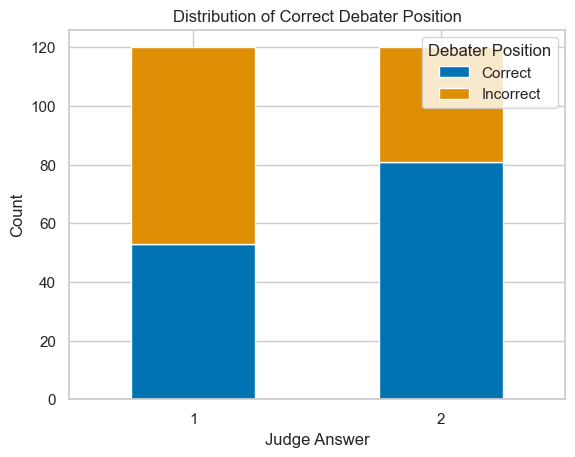

In [65]:
# Calculate overall position bias
position_counts = correct_exist_df.groupby(
    ["chosen_debater", "correct_debater_pos", "Judge Correct"], as_index=False
).agg(Count=("correct_debater_pos", "count"))
position_counts["Percentage"] = position_counts["Count"] / len(correct_exist_df)
position_counts["Judge Correct"] = position_counts["Judge Correct"].map(
    {0: "Incorrect", 1: "Correct"}
)

print("\nOverall position distribution:")
print(position_counts.to_string(index=False))

position_counts.pivot(
    index="correct_debater_pos", columns="Judge Correct", values="Count"
).plot(
    kind="bar",
    # figsize=(10, 6),
    title="Distribution of Correct Debater Position",
    rot=0,
    ylabel="Count",
    xlabel="Judge Answer",
    stacked=True,
)
plt.legend(title="Debater Position")
plt.show()


Accuracy by correct debater position:
 correct_debater_pos  Count  Baseline    Judge  Accuracy Gain
                   1    120  0.691667 0.441667      -0.250000
                   2    120  0.691667 0.675000      -0.016667


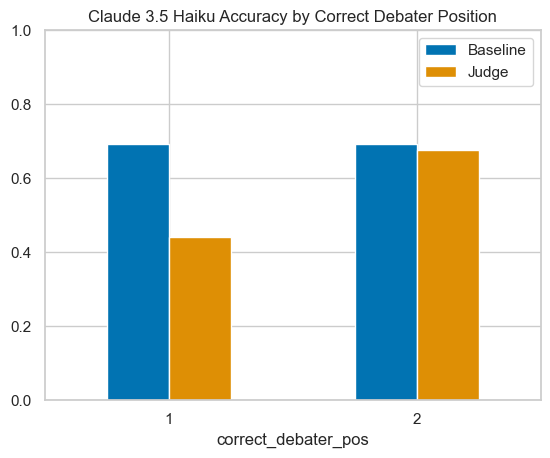

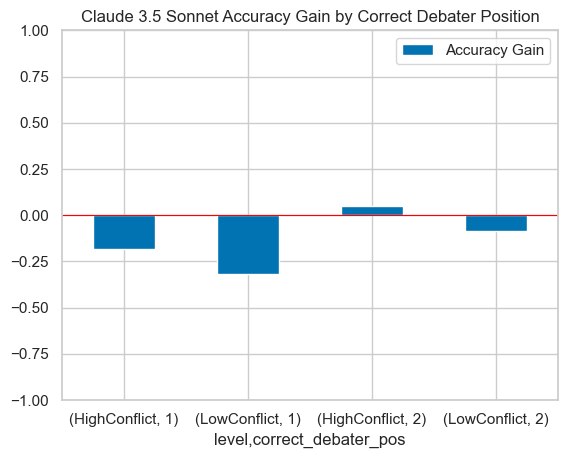

In [75]:
# Break down by correct debater position and accuracy gain based on the baseline
correct_debater_results = correct_exist_df.groupby(
    ["correct_debater_pos"], as_index=False
).agg(
    Count=("correct_debater_pos", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
correct_debater_results["Accuracy Gain"] = (
    correct_debater_results["Judge"] - correct_debater_results["Baseline"]
)

print("\nAccuracy by correct debater position:")
print(correct_debater_results.to_string(index=False))

correct_debater_results.plot(
    x="correct_debater_pos",
    y=["Baseline", "Judge"],
    kind="bar",
    title="Claude 3.5 Haiku Accuracy by Correct Debater Position",
    rot=0,
)
plt.ylim(0, 1)
plt.show()

# Plot again but comparing between level
correct_debater_results_ = correct_exist_df.groupby(
    ["correct_debater_pos", "level"], as_index=False
).agg(
    Count=("correct_debater_pos", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
correct_debater_results_["Accuracy Gain"] = (
    correct_debater_results_["Judge"] - correct_debater_results_["Baseline"]
)
correct_debater_results_.set_index(
    [
        "level",
        "correct_debater_pos",
    ]
).plot(
    # x="correct_debater_pos",
    y="Accuracy Gain",
    kind="bar",
    title="Claude 3.5 Sonnet Accuracy Gain by Correct Debater Position",
    ylim=(-1, 1),
    rot=0,
)
plt.axhline(0, color="red", linewidth=0.8)
plt.show()

In [ ]:
from scipy import stats

alpha = 0.05
print(f"\nSignificance level: {alpha}")

for level in answers_df["level"].unique():
    level_data = answers_df[answers_df["level"] == level]

    # Create contingency table for debater position vs judge accuracy
    contingency = pd.crosstab(
        level_data["correct_debater_pos"], level_data["judge"] == level_data["label"]
    )

    # Perform chi-square test
    chi2, p_value = stats.chi2_contingency(contingency)[:2]

    print(f"\n===== {level} =====")
    print("Contingency table:")
    print(contingency)
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p_value}")
    if p_value < alpha:
        print(
            "Reject null hypothesis: debater position is associated with judge accuracy"
        )
    else:
        print(
            "Fail to reject null hypothesis: debater position is not associated with judge accuracy"
        )

    # Calculate the effect size
    n = contingency.sum().sum()
    phi = np.sqrt(chi2 / n)
    print(
        f"Effect size: {phi:.2f} ({'Small' if phi < 0.1 else 'Medium' if phi < 0.3 else 'Large'})"
    )


Significance level: 0.05

===== HighConflict =====
Contingency table:
col_0                False  True 
correct_debater_pos              
-1                      60      0
 1                      36     24
 2                      22     38
Chi-square statistic: 54.52
p-value: 1.4480573007453176e-12
Reject null hypothesis: debater position is associated with judge accuracy
Effect size: 0.55 (Large)

===== LowConflict =====
Contingency table:
col_0                False  True 
correct_debater_pos              
-1                      60      0
 1                      31     29
 2                      17     43
Chi-square statistic: 66.81
p-value: 3.1142819659124323e-15
Reject null hypothesis: debater position is associated with judge accuracy
Effect size: 0.61 (Large)


### Do certain types of claims (proved/disproved/unknown) have systematically different success rates?


Accuracy by level and label:
       level     label  Count  Baseline    Judge  Accuracy Gain
HighConflict disproved     60      0.65 0.216667      -0.433333
HighConflict    proved     60      0.40 0.183333      -0.216667
HighConflict   unknown     60      0.70 0.633333      -0.066667
 LowConflict disproved     60      0.70 0.250000      -0.450000
 LowConflict    proved     60      0.90 0.316667      -0.583333
 LowConflict   unknown     60      0.80 0.633333      -0.166667


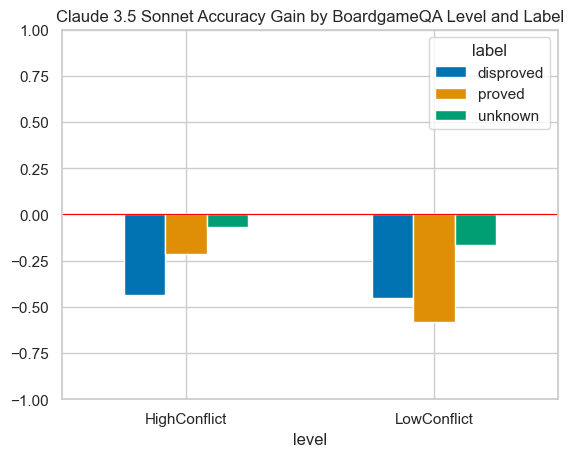

In [76]:
# Break down by level and label
level_label_results = answers_df.groupby(["level", "label"], as_index=False).agg(
    Count=("level", "count"),
    Baseline=("baseline", lambda x: (x == answers_df.loc[x.index, "label"]).mean()),
    Judge=("judge", lambda x: (x == answers_df.loc[x.index, "label"]).mean()),
)
level_label_results["Accuracy Gain"] = (
    level_label_results["Judge"] - level_label_results["Baseline"]
)

print("\nAccuracy by level and label:")
print(level_label_results.to_string(index=False))

level_label_results.pivot(index="level", columns="label", values="Accuracy Gain").plot(
    kind="bar",
    title="Claude 3.5 Sonnet Accuracy Gain by BoardgameQA Level and Label",
    ylim=(-1, 1),
    rot=0
)
# Add a horizontal line at 0
plt.axhline(0, color="red", linewidth=0.8)
plt.show()

### Is the judge better at selecting debaters who use evidence more accurately?

All: Judge accuracy when its selected debater give:
 - more correct quotes than other: 38.14%
 - equal correct quotes as other : 36.11%
 - otherwise                     : 38.71%
Judge is not more likely to be correct when its selected debater gives more correct quotes
t-statistic: 1.220
p-value: 0.223
Fail to reject null hypothesis: accuracy difference is not significant

HighConflict: Judge accuracy when its selected debater gave:
 - more correct quotes than other: 32.84%
 - equal correct quotes as other : 35.06%
 - otherwise                     : 36.11%
t-statistic: -0.041
p-value: 0.967
Fail to reject null hypothesis: accuracy difference is not significant

LowConflict: Judge accuracy when its selected debater gave:
 - more correct quotes than other: 45.10%
 - equal correct quotes as other : 36.89%
 - otherwise                     : 42.31%
t-statistic: 1.828
p-value: 0.069
Fail to reject null hypothesis: accuracy difference is not significant


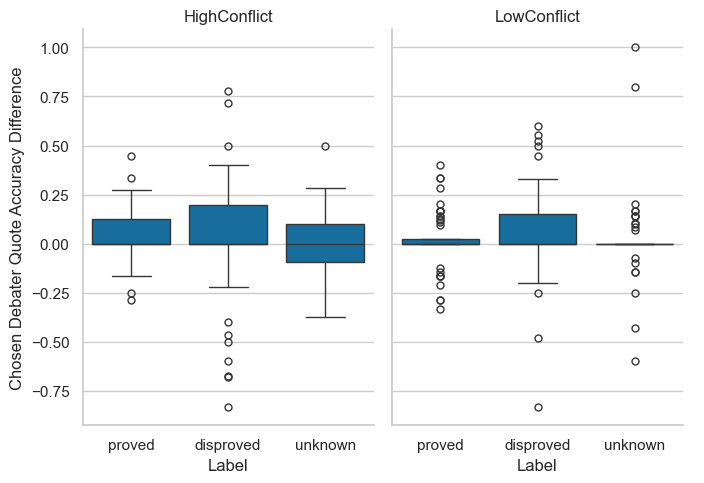

In [59]:
from scipy import stats

# Calculate average accuracy for positive and negative chosen_debater_quote_acc_diff
pos_acc = (
    answers_df[answers_df["chosen_debater_quote_acc_diff"] > 0]["judge"]
    == answers_df[answers_df["chosen_debater_quote_acc_diff"] > 0]["label"]
)
eq_acc = (
    answers_df[answers_df["chosen_debater_quote_acc_diff"] == 0]["judge"]
    == answers_df[answers_df["chosen_debater_quote_acc_diff"] == 0]["label"]
)
neg_acc = (
    answers_df[answers_df["chosen_debater_quote_acc_diff"] < 0]["judge"]
    == answers_df[answers_df["chosen_debater_quote_acc_diff"] < 0]["label"]
)

print("All: Judge accuracy when its selected debater give:")
print(f" - more correct quotes than other: {pos_acc.mean():.2%}")
print(f" - equal correct quotes as other : {eq_acc.mean():.2%}")
print(f" - otherwise                     : {neg_acc.mean():.2%}")

if pos_acc.mean() > neg_acc.mean():
    print(
        "Judge is more likely to be correct when its selected debater gives more correct quotes"
    )
else:
    print(
        "Judge is not more likely to be correct when its selected debater gives more correct quotes"
    )

# Perform t-test between chosen_debater_quote_acc_diff for correct vs incorrect judgements
correct_diffs = answers_df[answers_df["judge"] == answers_df["label"]][
    "chosen_debater_quote_acc_diff"
]
incorrect_diffs = answers_df[answers_df["judge"] != answers_df["label"]][
    "chosen_debater_quote_acc_diff"
]
t_stat, p_value = stats.ttest_ind(correct_diffs, incorrect_diffs)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.3f}")
if p_value < alpha:
    print("Reject null hypothesis: accuracy difference is significant")
else:
    print("Fail to reject null hypothesis: accuracy difference is not significant")

# Calculate and print statistics by level
for level in answers_df["level"].unique():
    level_data = answers_df[answers_df["level"] == level]
    pos_acc = (
        level_data[level_data["chosen_debater_quote_acc_diff"] > 0]["judge"]
        == level_data[level_data["chosen_debater_quote_acc_diff"] > 0]["label"]
    )
    eq_acc = (
        level_data[level_data["chosen_debater_quote_acc_diff"] == 0]["judge"]
        == level_data[level_data["chosen_debater_quote_acc_diff"] == 0]["label"]
    )
    neg_acc = (
        level_data[level_data["chosen_debater_quote_acc_diff"] < 0]["judge"]
        == level_data[level_data["chosen_debater_quote_acc_diff"] < 0]["label"]
    )

    print(f"\n{level}: Judge accuracy when its selected debater gave:")
    print(f" - more correct quotes than other: {pos_acc.mean():.2%}")
    print(f" - equal correct quotes as other : {eq_acc.mean():.2%}")
    print(f" - otherwise                     : {neg_acc.mean():.2%}")

    # Perform t-test between chosen_debater_quote_acc_diff for correct vs incorrect judgements
    correct_diffs = level_data[level_data["judge"] == level_data["label"]][
        "chosen_debater_quote_acc_diff"
    ]
    incorrect_diffs = level_data[level_data["judge"] != level_data["label"]][
        "chosen_debater_quote_acc_diff"
    ]
    t_stat, p_value = stats.ttest_ind(correct_diffs, incorrect_diffs)

    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.3f}")
    if p_value < alpha:
        print("Reject null hypothesis: accuracy difference is significant")
    else:
        print("Fail to reject null hypothesis: accuracy difference is not significant")

# Boxplots of chosen_debater_quote_acc_diff by label, faceted by level
g = sns.catplot(
    x="label",
    y="chosen_debater_quote_acc_diff",
    col="level",
    data=answers_df,
    kind="box",
    aspect=0.7,
)
g.set_axis_labels("Label", "Chosen Debater Quote Accuracy Difference")
g.set_titles("{col_name}")
plt.show()

In [61]:
# Statistical test for scenario level bias
print("\nTesting for scenario level bias:")
contingency = pd.crosstab(
    answers_df["level"], answers_df["judge"] == answers_df["label"]
)
# Perform chi-square test
chi2, p_value = stats.chi2_contingency(contingency)[:2]
print("Contingency table:")
print(contingency)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")
if p_value < alpha:
    print("Reject null hypothesis: scenario level is associated with judge accuracy")
else:
    print(
        "Fail to reject null hypothesis: scenario level is not associated with judge accuracy"
    )


Testing for scenario level bias:
Contingency table:
col_0         False  True 
level                     
HighConflict    118     62
LowConflict     108     72
Chi-square statistic: 0.96
p-value: 0.3265
Fail to reject null hypothesis: scenario level is not associated with judge accuracy
